# U-Net Denoising

3


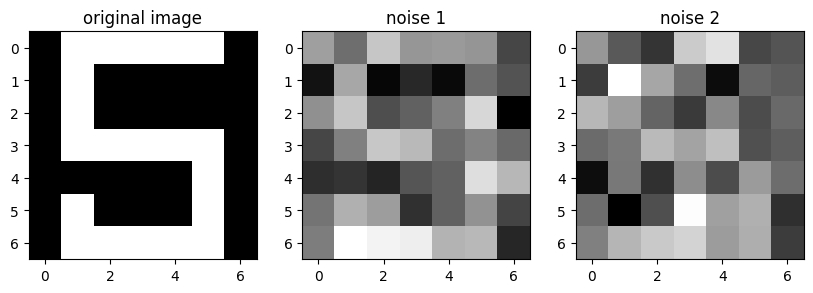

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

# 1. create number 5 from 7x7 matrix
image = torch.tensor([
    [0, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 1, 0]
], dtype=torch.float32)

# 2. Gaussian blur
num_steps = 3
timesteps = torch.linspace(0, 1, num_steps)
def noising_process(x0, t):
    noise = torch.randn_like(x0) * t
    return x0 + noise

noisy_images = [noising_process(image, t) for t in timesteps]

print(len(noisy_images))

# plot image
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i, noisy_img in enumerate(noisy_images):
    if i == 0:
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title("original image")
    else:
        axes[i].imshow(noisy_img, cmap='gray')
        axes[i].set_title(f"noise {i}")
plt.show()

Epoch [0/400], Loss: 0.4313
Epoch [100/400], Loss: 0.0118
Epoch [200/400], Loss: 0.0124
Epoch [300/400], Loss: 0.0050


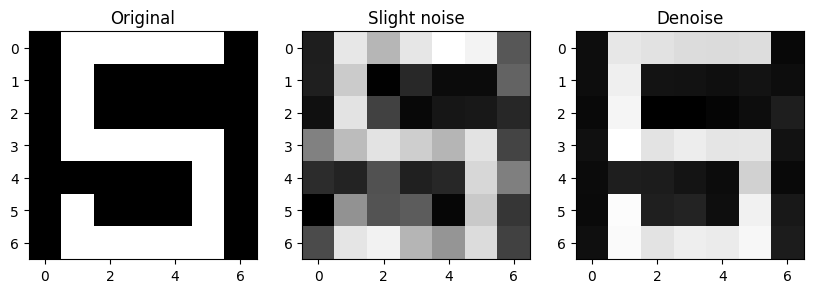

In [2]:
# 3. UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 4.training
num_epochs = 400
for epoch in range(num_epochs):
    t = torch.rand(1)  # random t
    noisy_image = noising_process(image, t).unsqueeze(0).unsqueeze(0)
    clean_image = image.unsqueeze(0).unsqueeze(0)

    optimizer.zero_grad()
    output = model(noisy_image)
    loss = criterion(output, clean_image)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# 5. predict with noise
noisy_test = noising_process(image, torch.tensor(0.2)).unsqueeze(0).unsqueeze(0)
denoised_output = model(noisy_test).squeeze().detach()

# oringinal, slight noise, denoise image
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(noisy_test.squeeze(), cmap='gray')
axes[1].set_title("Slight noise")
axes[2].imshow(denoised_output, cmap='gray')
axes[2].set_title("Denoise")
plt.show()

# Diffusion Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

def sinusoidal_embedding(t, dim):
    if isinstance(t, int):  # Đảm bảo t là tensor
        t = torch.tensor([t], dtype=torch.float32)

    half_dim = dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)  # [half_dim]

    emb = t.unsqueeze(0) * emb.unsqueeze(0)  # [1] x [half_dim] -> [1, half_dim]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)  # [1, dim]

    return emb


class SmallUNet(nn.Module):
    def __init__(self, input_channels, output_channels, T, hidden_dim=64):
        super().__init__()
        self.time_embed = sinusoidal_embedding(T, hidden_dim)

        # Encoder
        self.conv1 = nn.Conv2d(input_channels, hidden_dim//2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim//2, hidden_dim, kernel_size=3, padding=1)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(hidden_dim + hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(hidden_dim*2, hidden_dim, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)

        # Output
        self.mu_conv = nn.Conv2d(hidden_dim//2, output_channels, kernel_size=3, padding=1)
        self.sigma_conv = nn.Conv2d(hidden_dim//2, output_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # take time embedding and convert to tensor 2D
        batch_size = x.shape[0]

        # create time embedding
        t_emb = self.time_embed.to(x.device)

        t_emb = t_emb.view(1, -1, 1, 1).expand(batch_size, -1, x.shape[2], x.shape[3])


        # Encoder
        x1 = torch.relu(self.conv1(x))
        x2 = torch.relu(self.conv2(x1))

        # combine with time embedding
        x_t = torch.cat([x2, t_emb], dim=1)

        # Bottleneck
        x_bottleneck = self.bottleneck(x_t)

        # Decoder
        x_up1 = torch.relu(self.upconv1(x_bottleneck))
        x_up2 = torch.relu(self.upconv2(x_up1))

        # Output
        mu = self.mu_conv(x_up2)
        # Clamp to avoid too low or too big value
        sigma = torch.exp(self.sigma_conv(x_up2)).clamp(min=1e-5, max=1e5)

        return mu, sigma

class DiffusionModel():
    def __init__(self, T, model: nn.Module, device, dim=2):
        self.betas = (torch.sigmoid(torch.linspace(-17, 10, T)) * (3e-1 - 1e-5) + 1e-5).to(device)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        self.T = T
        self.model = model
        self.dim = dim
        self.device = device

    def forward_process(self, x0, t):
        """
        :param t: Number of diffusion steps
        """
        assert 1 <= t <= self.T, f't should be in range [1, {self.T}]'

        t = t.to(self.device)
        t_idx = t - 1  # index 0->t-1
        mu = torch.sqrt(self.alphas_bar[t_idx]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t_idx])
        epsilon = torch.randn_like(x0)
        xt = mu + epsilon * std

        std_q = torch.sqrt((1 - self.alphas_bar[t_idx-1])/ (1 - self.alphas_bar[t_idx]) * self.betas[t_idx])
        m1 = torch.sqrt(self.alphas_bar[t_idx-1]) * self.betas[t_idx] / (1 - self.alphas_bar[t_idx])
        m2 = torch.sqrt(self.alphas[t_idx]) * (1 - self.alphas_bar[t_idx-1]) / (1 - self.alphas_bar[t_idx])
        mu_q = m1 * x0 + m2 * xt

        return mu_q, std_q, xt

    def reverse_process(self, xt, t):
        """
        :param t: Number of diffusion steps
        """
        assert 1 <= t <= self.T, f't should be in range [1, {self.T}]'

        t = torch.tensor([t-1], device=self.device)

        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)
        return mu, std, mu + epsilon * std  # image denosing ~ N(mu, std)

    def sample(self, batch_size, device):
        # create noise
        noise = torch.randn((batch_size, *self.dim)).to(device)
        x = noise
        samples = [x]
        for t in range(self.T, 0, -1):
            mu, std, x_new = self.reverse_process(x, t)
            x = x_new
            samples.append(x)
        return samples

    def get_loss(self, x0):
        """
        :param x0: batch [batch_size, ...]
        """
        t = torch.randint(2, self.T+1, (1,), device=self.device)
        mu_q, sigma_q, xt = self.forward_process(x0, t)
        mu_p, sigma_p, _ = self.reverse_process(xt.float(), t.item())

        # add epsilon to avoid log(0) and divided by 0
        epsilon = 1e-8
        KL = torch.log(sigma_p + epsilon) - torch.log(sigma_q + epsilon) + (sigma_q**2 + (mu_q - mu_p)**2) / (2 * (sigma_p**2 + epsilon))
        K = - KL.mean()  # Should be maximized
        loss = - K  # Should be minimized
        return loss

    def save_model(self, path):
        """Lưu trạng thái mô hình."""
        torch.save({'model_state_dict': self.model.state_dict()}, path)

    def load_model(self, path):
        """Tải mô hình đã lưu."""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])

# Train

In [ ]:
# create folder to save model
os.makedirs('models', exist_ok=True)

# create param
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

T = 4  # Số bước khuyếch tán
hidden_dim = 64
epochs = 6000


image_5 = np.array([
    [0, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 1, 0]
], dtype=np.float32)

# changing shape
image_tensor = torch.from_numpy(image_5).unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, 7, 7]


# crate model
model = SmallUNet(input_channels=1, output_channels=1, T=T, hidden_dim=hidden_dim).to(device)
diffusion = DiffusionModel(T, model, device, dim=(1, 7, 7))  # use the size of the image as dim

# optimizer with smaller learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# param to surveil the smallest loss
best_loss = float('inf')

# training loop
losses = []
no_improve_count = 0

for epoch in range(epochs):
    x_batch = image_tensor.to(device)

    # loss
    optimizer.zero_grad()
    loss = diffusion.get_loss(x_batch)

    # update model
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    loss_val = loss.item()
    losses.append(loss_val)

    # save the best model
    if loss_val < best_loss:
        best_loss = loss_val
        diffusion.save_model(f'models/best_diffusion_model.pth')
        print(f"New best model saved at epoch {epoch+1} with loss: {best_loss:.4f}")

print("Training complete")

Sử dụng thiết bị: cuda
New best model saved at epoch 1 with loss: 1.1867
New best model saved at epoch 7 with loss: 1.1838
New best model saved at epoch 10 with loss: 1.1560
New best model saved at epoch 36 with loss: 1.1204
New best model saved at epoch 41 with loss: 1.0558
New best model saved at epoch 45 with loss: 1.0091
New best model saved at epoch 78 with loss: 1.0008
New best model saved at epoch 250 with loss: 0.9045
New best model saved at epoch 255 with loss: 0.8360
New best model saved at epoch 257 with loss: 0.7508
New best model saved at epoch 261 with loss: 0.7387
New best model saved at epoch 360 with loss: 0.6817
New best model saved at epoch 732 with loss: 0.6598
New best model saved at epoch 742 with loss: 0.6476
New best model saved at epoch 817 with loss: 0.6115
New best model saved at epoch 818 with loss: 0.6084
New best model saved at epoch 959 with loss: 0.6030
New best model saved at epoch 1027 with loss: 0.5925
New best model saved at epoch 1184 with loss: 0.5

#Visualize

Đang tải mô hình tốt nhất để đánh giá...
4


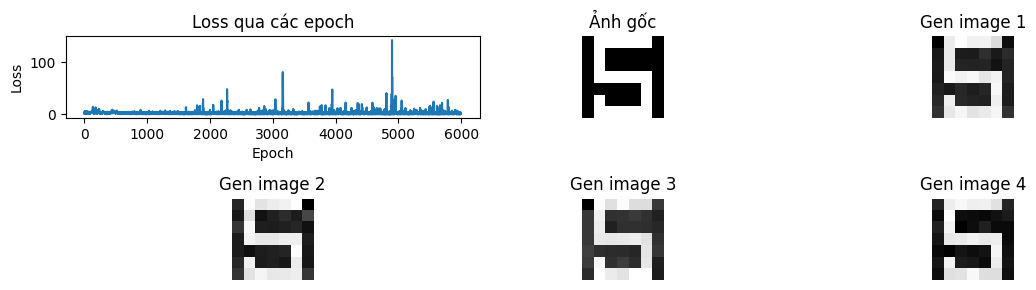

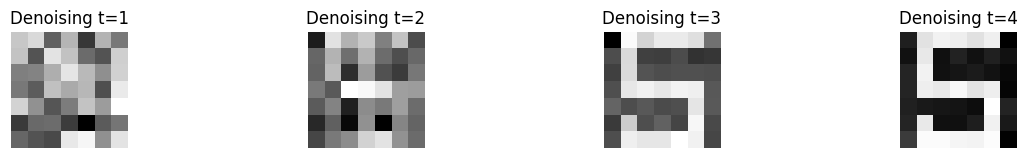

In [ ]:
# Tải mô hình tốt nhất để đánh giá
print("Đang tải mô hình tốt nhất để đánh giá...")
best_model = SmallUNet(input_channels=1, output_channels=1, T=T, hidden_dim=hidden_dim).to(device)
best_diffusion = DiffusionModel(T, best_model, device, dim=(1, 7, 7))
best_diffusion.load_model('models/best_diffusion_model.pth')

# Test mô hình với ảnh gốc
def test_model(diffusion_model, image_shape, num_samples=4):
    """
    Test mô hình bằng cách tạo ra các mẫu từ nhiễu
    """
    with torch.no_grad():
        diffusion_model.model.eval()
        samples = diffusion_model.sample(num_samples, device)
        final_samples = samples[-1].cpu()
        print(len(final_samples))

    # Hiển thị kết quả
    plt.figure(figsize=(12, 3))

    # Vẽ loss
    plt.subplot(2, 3, 1)
    plt.plot(losses)
    plt.title('Loss qua các epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Vẽ hình ảnh gốc
    plt.subplot(2, 3, 2)
    plt.imshow(image_5, cmap='gray')
    plt.title('Ảnh gốc')
    plt.axis('off')

    # Vẽ các mẫu được tạo
    for i in range(num_samples):
        plt.subplot(2, 3, i+3)
        plt.imshow(final_samples[i, 0].numpy(), cmap='gray')
        plt.title(f'Gen image {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('best_model_results.png')
    plt.show()

    # Hiển thị quá trình khuyếch tán
    plt.figure(figsize=(12, 3))
    # Chọn một số bước từ quá trình khuyếch tán để hiển thị
    steps = np.arange(diffusion_model.T)  # Lấy tất cả các bước từ 0 đến T

    for i, step in enumerate(steps):
        plt.subplot(2, 4, i+1)
        sample = samples[step][0, 0].cpu().numpy()
        plt.imshow(sample, cmap='gray')
        plt.title(f'Denoising t={step+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('best_model_diffusion_process.png')
    plt.show()

# Kiểm tra mô hình tốt nhất
test_model(best_diffusion, (1, 7, 7))

#Forward

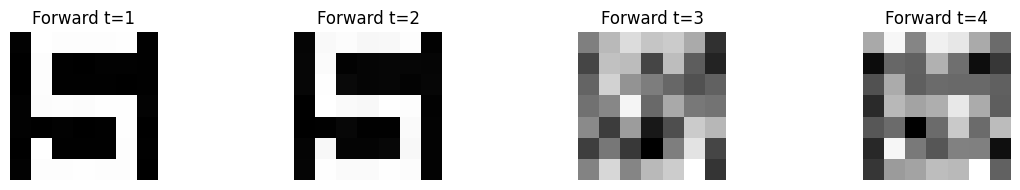

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_forward_process(diffusion_model, x0, t=10):
    """
    Hiển thị quá trình forward process.
    """
    device = diffusion_model.device
    x0 = x0.to(device)

    # Forward process
    forward_steps = []
    xt = x0
    for i in range(1, t+1):
        mu_q, std_q, xt = diffusion_model.forward_process(x0, torch.tensor(i, device=device))
        forward_steps.append(xt.cpu().numpy())

    # Hiển thị kết quả
    fig, axes = plt.subplots(1, t, figsize=(t*3, 2))

    for i in range(t):
        axes[i].imshow(forward_steps[i][0, 0], cmap='gray')
        axes[i].set_title(f'Forward t={i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị quá trình forward
visualize_forward_process(best_diffusion, image_tensor, t=4)


# Output forward ---> Reserve

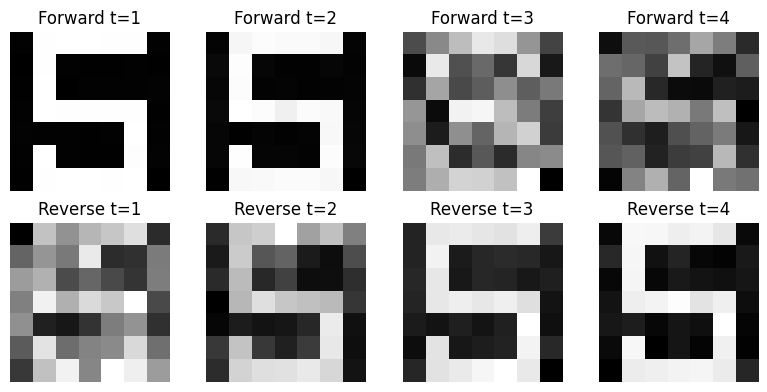

In [ ]:
def visualize_forward_reverse_process(diffusion_model, x0, t=10):
    """
    Hiển thị quá trình forward process và reverse process với t=4.
    """
    device = diffusion_model.device
    x0 = x0.to(device)

    # Forward process
    forward_steps = []
    xt = x0
    for i in range(1, t+1):
        mu_q, std_q, xt = diffusion_model.forward_process(x0, torch.tensor(i, device=device))
        forward_steps.append(xt.cpu().numpy())

    # Reverse process
    reverse_steps = []
    xt_reverse = xt  # Bắt đầu từ xt cuối cùng của forward process
    for i in range(t, 0, -1):
        mu_p, sigma_p, xt_reverse = diffusion_model.reverse_process(xt_reverse, i)
        reverse_steps.append(xt_reverse.detach().cpu().numpy())

    # Hiển thị kết quả
    fig, axes = plt.subplots(2, t, figsize=(t*2, 4))

    # Hiển thị forward process
    for i in range(t):
        axes[0, i].imshow(forward_steps[i][0, 0], cmap='gray')
        axes[0, i].set_title(f'Forward t={i+1}')
        axes[0, i].axis('off')

    # Hiển thị reverse process
    for i in range(t):
        axes[1, i].imshow(reverse_steps[i][0, 0], cmap='gray')
        axes[1, i].set_title(f'Reverse t={i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig('forward_reverse_process.png')
    plt.show()


visualize_forward_reverse_process(best_diffusion, image_tensor, t=4)


# Random noisy ---> Reverse

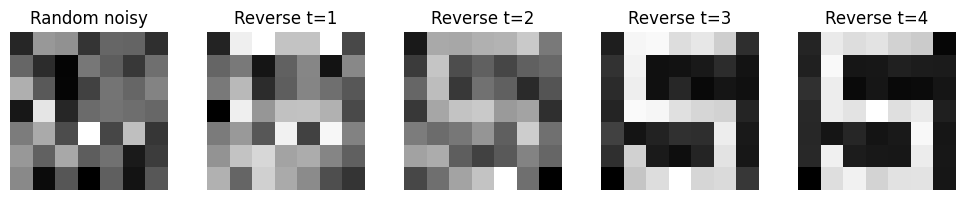

In [ ]:
def visualize_reverse_process(diffusion_model, t=4):
    """
    Hiển thị quá trình reverse process từ noise.
    """
    device = diffusion_model.device

    # Khởi tạo noise ngẫu nhiên
    xt_reverse = torch.randn((1, 1, 7, 7), device=device)  # Kích thước ảnh 7x7


    # Reverse process
    reverse_steps = [xt_reverse.cpu().numpy()]
    for i in range(t, 0, -1):
        mu_p, sigma_p, xt_reverse = diffusion_model.reverse_process(xt_reverse, i)
        reverse_steps.append(xt_reverse.detach().cpu().numpy())

    # Hiển thị kết quả
    fig, axes = plt.subplots(1, t+1, figsize=((t+1)*2, 2))

    for i in range(t+1):
        if i == 0:
            axes[i].imshow(reverse_steps[i][0, 0], cmap='gray')
            axes[i].set_title(f'Random noisy')
            axes[i].axis('off')
        else:
            axes[i].imshow(reverse_steps[i][0, 0], cmap='gray')
            axes[i].set_title(f'Reverse t={i}')
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('reverse_process.png')
    plt.show()
visualize_reverse_process(best_diffusion, t=4)